In [1]:
import os
import json
import torch
import gensim
import numpy as np
import transformers
from typing import Callable
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder

In [3]:
model = "Embeddings/GoogleNews-vectors-negative300.bin.gz"     # Word2Vec
embedding = gensim.models.KeyedVectors.load_word2vec_format(model, binary=True)

In [39]:
from gensim.test.utils import get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec

target = get_tmpfile("temp.txt")
glove2word2vec("Embeddings/glove.42B.300d/glove.42B.300d.txt", target)

model = gensim.models.KeyedVectors.load_word2vec_format(target)

model.save_word2vec_format("Embeddings/glove.42B.300d.bin.gz", binary=True)

C:\Users\Divyajeet Singh\AppData\Local\Temp\ipykernel_4932\4275181089.py:5: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec("Embeddings/glove.42B.300d/glove.42B.300d.txt", target)


In [5]:
model = "Embeddings/glove.42B.300d.bin.gz"                       # GloVe
embedding = gensim.models.KeyedVectors.load_word2vec_format(model, binary=True)

In [7]:
model = "Embeddings/cc.en.300.bin.gz"                          # FastText
embedding = gensim.models.fasttext.load_facebook_model(model)

In [338]:
def load_dataset(dataset: int, embeddings: str):
    """
    Loads the given dataset and returns the train, test, and validation
    sets with the corresponding labels.
    :params:
        - dataset: The dataset to load. Must be 1 or 2.
        - embeddings: The word-embeddings to use. Must be "Word2Vec", "GloVe", or "FastText" (case-insensitive).
    """

    embeddings_err = "Invalid embeddings. Must be 'Word2Vec', 'GloVe', or 'FastText'."
    dataset_err = "Invalid dataset number. Must be 1 or 2."
    embeddings = embeddings.casefold()

    path = r"Assignment-2/Datasets/preprocessed/"
    train_path, test_path, val_path = [
        os.path.join(path, dataset, f"{dataset}_{x}.json") for x in ["train", "test", "val"]
    ]

    assert embeddings in ["word2vec", "glove", "fasttext"], embeddings_err

    # path = rf"Assignment-2/Datasets/preprocessed/dataset_{dataset}"
    # train_path, test_path, val_path = [os.path.join(path, f"{x}.json") for x in ["train", "test", "val"]]

    with open(train_path) as train, open(test_path) as test, open(val_path) as val:
        train_data = json.load(train)
        test_data = json.load(test)
        val_data = json.load(val)

    print("Loading Embeddings...")
    if embeddings == "word2vec":
        model = "Assignment-2/Embeddings/GoogleNews-vectors-negative300.bin.gz"
        embedding = gensim.models.KeyedVectors.load_word2vec_format(model, binary=True)
    elif embeddings == "glove":
        model = "Assignment-2/Embeddings/glove.42B.300d.bin.gz"
        embedding = gensim.models.KeyedVectors.load_word2vec_format(model, binary=True)
    else:
        model = "Assignment-2/Embeddings/cc.en.300.bin.gz"
        embedding = gensim.models.fasttext.load_facebook_model(model).wv

    LABELS = set()
    for data in train_data.values():
        LABELS.update(data["labels"])
    encoder = LabelEncoder()
    encoder.fit(sorted(LABELS))

    print("Preprocessing Data...")
    DATA = [[], []], [[], []], [[], []]
    for i, dataset in enumerate([train_data, test_data, val_data]):
        for data in dataset.values():
            DATA[i][0].append(data["text"].split())
            DATA[i][1].append(data["labels"])
    (TRAIN_DATA, TRAIN_LABELS), (TEST_DATA, TEST_LABELS), (VAL_DATA, VAL_LABELS) = DATA

    train_set = CustomDataset(TRAIN_DATA, TRAIN_LABELS, encoder, embedding)
    test_set = CustomDataset(TEST_DATA, TEST_LABELS, encoder, embedding)
    val_set = CustomDataset(VAL_DATA, VAL_LABELS, encoder, embedding)

    return train_set, test_set, val_set

In [354]:
class CustomDataset(Dataset):
    """
    A custom dataset class for dataset_1 and dataset_2.
    :attrs:
        - data: The data of the dataset. Each element is a list of words.
        - labels: The labels of the dataset. Each element is a list of labels
            for each word of the sentence.
        - encoder: The (already fitted) label-encoder for the labels.
        - embedding: The word-embedding to use for the dataset. It must have
            a key_to_index attribute attribute (to convert words to indices).

    The dataset preprocesses the input data and labels. 'data' is stored as
    a Tensor of word-indices, and 'labels' is stored as a Tensor of label-indices.
    """

    data: torch.Tensor
    labels: torch.Tensor
    encoder: LabelEncoder
    embeddings: gensim.models.keyedvectors.KeyedVectors | gensim.models.fasttext.FastTextKeyedVectors

    def __init__(self, data: list[list[str]], labels: list[list[str]], encoder, embeddings):
        super(CustomDataset, self).__init__()
        self.data = data
        self.labels = labels
        self.encoder = encoder
        self.embeddings = embeddings
        self._encode()
        self._pad()

    def __len__(self) -> int:
        """
        Returns the length of the dataset.
        """
        return len(self.data)

    def __getitem__(self, index: int) -> tuple[torch.Tensor]:
        """
        Returns the data and target at the given index. Converts each
        sentence into a tensor of word indices using the chosen word-embeddings.
        """
        return self.data[index], self.labels[index]

    def _encode(self) -> None:
        """
        Converts all sentences to their corresponding word-indices and
        encodes the labels using the label-encoder.
        """
        unk = len(self.embeddings.key_to_index) - 1
        self.data = [
            torch.tensor([self.embeddings.key_to_index.get(word, unk) for word in sentence])
            for sentence in self.data
        ]
        self.labels = [torch.LongTensor(self.encoder.transform(label)) for label in self.labels]

    def _pad(self) -> None:
        """
        Pads all sentences to the maximum length. Currently, the padding
        value for the labels is set to "O", which may not be ideal.
        """
        padding_value = self.encoder.transform(["O"])[0]
        self.data = torch.nn.utils.rnn.pad_sequence(self.data, batch_first=True)
        self.labels = torch.nn.utils.rnn.pad_sequence(self.labels, batch_first=True, padding_value=padding_value)

In [355]:
train_set, test_set, val_set = load_dataset("NER", "Word2Vec")

encoder = train_set.encoder
embeddings = train_set.embeddings
# # This part handles the <UNK> token, i.e. OOV words. Currently, OOV words are directly set to 0s, which is not ideal.
embedding_matrix = torch.FloatTensor(embeddings.vectors)
embedding_matrix = torch.cat([embedding_matrix, torch.zeros(1, embedding_matrix.shape[1])])
embedding.key_to_index["<UNK>"] = len(embedding.key_to_index)
embedding.index_to_key.append("<UNK>")

Loading Embeddings...
Preprocessing Data...


In [203]:
FASTTEXT_MODEL = e

In [206]:
type(FASTTEXT_MODEL.wv)

gensim.models.fasttext.FastTextKeyedVectors

In [6]:
os.chdir("..")

In [305]:
EMBEDING_LAYER = torch.nn.Embedding.from_pretrained(embedding_matrix)
word_embedding = EMBEDING_LAYER(torch.tensor([embedding.key_to_index.get(word) for word in "the quick brown fox".split()]))
word_embedding.shape

torch.Size([4, 300])

In [306]:
subset = train_data[:5]
for sentence in subset:
    print(sentence)

['He', 'was', 'also', 'asked', 'whether', 'Agya', '<span', 'class="hidden_text"', 'id="span_5">', 'CRA', 'No.326-DB', 'of', '1998', '6</span>', 'Kaur,', 'mother-in-law', 'of', 'the', 'deceased', 'lived', 'separately', 'from', 'Tarlochan', 'Singh.']
['5.2', 'CW3', 'Mr', 'Vijay', 'Mishra', ',', 'Deputy', 'Manager,', 'HDFC', 'Bank,', 'Noida,', 'UP', 'has', 'deposed', 'that', 'complainant', 'had', 'a', 'current', 'account', 'with', 'HDFC', 'Bank', 'in', 'the', 'year', '2004\xad2005.']
['You', 'are', 'hereby', 'asked', 'not', 'to', 'carry', 'out', 'any', 'construction', 'work', 'of', 'the', 'said', 'building', 'hereafter', 'since', 'the', 'agreement', 'has', 'been', 'terminated".']
['After', 'all', 'the', 'steps', 'at', 'the', 'stage', 'of', 'investigation', 'has', 'to', 'be', 'reported', 'before', 'the', 'Court', 'and', 'the', 'order', 'passed', 'thereon', 'is', 'obviously', 'judicial', 'order', 'and', 'this', 'takes', 'clear', 'note', 'of', 'the', 'agony', 'of', 'the', 'learned', 'Counsel

In [307]:
subset = [[embedding.key_to_index.get(word, len(embedding.key_to_index)-1) for word in sentence] for sentence in subset]
for sentence in subset:
    print(len(sentence), sentence)

24 [57, 10, 53, 438, 369, 817011, 3000000, 3000000, 3000000, 30909, 3000000, 3000000, 3000000, 3000000, 3000000, 3000000, 3000000, 11, 9895, 1958, 8019, 17, 1219623, 3000000]
27 [3000000, 863288, 602, 30124, 33742, 3000000, 3562, 3000000, 38263, 3000000, 3000000, 13860, 24, 20696, 3, 21322, 35, 3000000, 403, 1201, 8, 38263, 669, 1, 11, 36, 3000000]
22 [228, 19, 29224, 438, 13, 3000000, 1635, 49, 101, 984, 141, 3000000, 11, 9, 473, 65530, 140, 11, 729, 24, 42, 3000000]
37 [361, 52, 11, 1830, 12, 11, 943, 3000000, 915, 24, 3000000, 16, 343, 99, 11, 1557, 3000000, 11, 555, 1126, 68081, 4, 2633, 5481, 555, 3000000, 28, 920, 645, 1734, 3000000, 11, 20599, 3000000, 11, 1638, 3000000]
8 [3000000, 2165064, 4, 11, 2520, 1722, 3000000, 3000000]


In [308]:
padded = torch.nn.utils.rnn.pad_sequence([torch.tensor(sentence) for sentence in subset], batch_first=True)
for row in padded:
    x = (list(i.item() for i in row))
    print(len(x), x)

37 [57, 10, 53, 438, 369, 817011, 3000000, 3000000, 3000000, 30909, 3000000, 3000000, 3000000, 3000000, 3000000, 3000000, 3000000, 11, 9895, 1958, 8019, 17, 1219623, 3000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
37 [3000000, 863288, 602, 30124, 33742, 3000000, 3562, 3000000, 38263, 3000000, 3000000, 13860, 24, 20696, 3, 21322, 35, 3000000, 403, 1201, 8, 38263, 669, 1, 11, 36, 3000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
37 [228, 19, 29224, 438, 13, 3000000, 1635, 49, 101, 984, 141, 3000000, 11, 9, 473, 65530, 140, 11, 729, 24, 42, 3000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
37 [361, 52, 11, 1830, 12, 11, 943, 3000000, 915, 24, 3000000, 16, 343, 99, 11, 1557, 3000000, 11, 555, 1126, 68081, 4, 2633, 5481, 555, 3000000, 28, 920, 645, 1734, 3000000, 11, 20599, 3000000, 11, 1638, 3000000]
37 [3000000, 2165064, 4, 11, 2520, 1722, 3000000, 3000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [114]:
EMBEDING_LAYER(padded).shape

torch.Size([5, 37, 300])

In [369]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=True)

for data, labels in train_loader:
    print(data.shape, labels.shape)
    break

torch.Size([128, 70]) torch.Size([128, 70])


In [370]:
class RNN(torch.nn.Module):
    input_size: int
    hidden_size: int
    num_layers: int
    output_size: int
    embedding_matrix: torch.Tensor

    def __init__(self, input_size, hidden_size, num_layers, output_size, embedding_matrix):
        super(RNN, self).__init__()
        self.embedding = torch.nn.Embedding.from_pretrained(embedding_matrix)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = torch.nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)
        self.softmax = torch.nn.LogSoftmax(dim=2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)
        hidden = torch.zeros(self.num_layers, x.shape[0], self.hidden_size)
        output, _ = self.rnn(x, hidden)
        output = self.fc(output)
        return self.softmax(output)


model = RNN(300, 128, 2, 27, embedding_matrix)
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for epoch in range(10):
    total_loss = 0
    for data, labels in train_loader:
        output = model(data)
        output = output.permute(0, 2, 1)
        # only consider the words which were not padded
        mask = (data != 0)
        labels = labels * mask
        mask = mask.unsqueeze(1).repeat(1, 27, 1)
        output = output * mask.float()
        loss = criterion(output, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    total_loss /= len(train_loader)
    print(f"Epoch {epoch+1} Loss: {total_loss}")

Epoch 1 Loss: 0.4421174942501008
Epoch 2 Loss: 0.2991996251401447
Epoch 3 Loss: 0.2604514216146772
Epoch 4 Loss: 0.24270207730550614
Epoch 5 Loss: 0.2020429720481237
Epoch 6 Loss: 0.19433646235201094
Epoch 7 Loss: 0.18486985398663414
Epoch 8 Loss: 0.18023936805270968
Epoch 9 Loss: 0.17515609590780168
Epoch 10 Loss: 0.16338102673254315


In [371]:
# Calculate true positives and negatives, and false positives and negatives

model.eval()

true = []
predicted = []

loader = test_loader
with torch.no_grad():
    total_loss = 0
    for p, (data, labels) in enumerate(loader):
        output = model(data).permute(0, 2, 1)
        mask = (data != 0)
        labels = labels * mask
        output = output * mask.unsqueeze(1).repeat(1, 27, 1).float()
        total_loss += (loss := criterion(output, labels)).item()
        true.extend(labels.flatten().tolist())
        predicted.extend(output.argmax(dim=1).flatten().tolist())

        print(p, "of", len(loader), end="\r")
    total_loss /= len(loader)

print()
print(f"Test Loss: {total_loss:.4f}")

7 of 8
Test Loss: 0.1823


c:\Users\Divyajeet Singh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9512
Precision: 0.4423
Recall: 0.3812
F1-Score: 0.3952


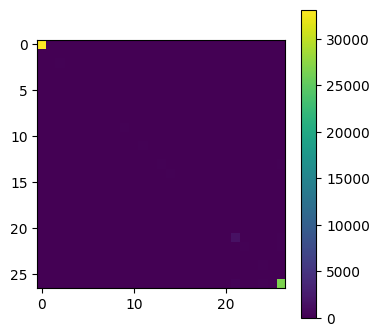

In [372]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

cf_matrix = confusion_matrix(true, predicted)
acc = accuracy_score(true, predicted)
prec = precision_score(true, predicted, average="macro")
rec = recall_score(true, predicted, average="macro")
f1 = f1_score(true, predicted, average="macro")

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")

plt.figure(figsize=(4, 4))
plt.imshow(cf_matrix)
plt.colorbar()
plt.show()